# Decision Tree-Based Risk Detection System for S&P 500 Stocks

## Setup

In [15]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree, _tree
from sklearn.metrics import confusion_matrix, classification_report

## Strategy Class Definition

In [16]:
class Strategy:
    def __init__(self):
        """Initialize strategy variables"""
        self.data = None
        self.model = None
        self.factors = None

    def fetch_data(self, tickers, start_date, end_date):
        data_frames = []
        for ticker in tickers:
            try:
                df = yf.download(ticker, start=start_date, end=end_date)
                df['Ticker'] = ticker
                data_frames.append(df)
            except Exception as e:
                print(f"Error fetching {ticker}: {e}")
        
        self.data = pd.concat(data_frames)
        return self.data
        
        self.data = processed_data
        return self.data

In [17]:
trader = Strategy()

# Test data fetching with multiple stocks

test_tickers = ['AAPL', 'MSFT', 'GOOG']
print("Fetching data for tickers:", test_tickers)
test_data = trader.fetch_data(test_tickers, '2019-01-01', '2023-12-01')

print("\nNumber of rows per ticker:")
print(test_data.groupby('Ticker').size())

print("\nSample of data:")
print(test_data.groupby('Ticker').head(3))


print("Data shape:", test_data.shape)
print("\nFirst few rows:")
print(test_data.head())
print("\nColumns:", test_data.columns.tolist())

# checking for null values
print("\nMissing values:")
print(test_data.isnull().sum())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Fetching data for tickers: ['AAPL', 'MSFT', 'GOOG']

Number of rows per ticker:
Ticker
AAPL    1238
GOOG    1238
MSFT    1238
dtype: int64

Sample of data:
                  Open        High        Low       Close  Adj Close  \
Date                                                                   
2019-01-02   38.722500   39.712502  38.557499   39.480000  37.708591   
2019-01-03   35.994999   36.430000  35.500000   35.547501  33.952541   
2019-01-04   36.132500   37.137501  35.950001   37.064999  35.401955   
2019-01-02   99.550003  101.750000  98.940002  101.120003  95.310547   
2019-01-03  100.099998  100.190002  97.199997   97.400002  91.804245   
2019-01-04   99.720001  102.510002  98.930000  101.930000  96.074005   
2019-01-02   50.828499   52.616001  50.785500   52.292500  52.105282   
2019-01-03   52.049999   52.848999  50.703499   50.803001  50.621113   
2019-01-04   51.629501   53.542000  51.370899   53.535500  53.343830   

               Volume Ticker  
Date                

## Trading Factors 

In [18]:
def calculate_factors(self):
        """Calculate trading factors"""
        print("Starting factor calculations...")
        processed_data = self.data.copy()
        
        for ticker in processed_data['Ticker'].unique():
            print(f"Processing {ticker}...")
            ticker_mask = processed_data['Ticker'] == ticker
            ticker_data = processed_data[ticker_mask]
            
            # Momentum Factors
            processed_data.loc[ticker_mask, 'Returns_1M'] = ticker_data['Adj Close'].pct_change(21)
            processed_data.loc[ticker_mask, 'Returns_3M'] = ticker_data['Adj Close'].pct_change(63)
            processed_data.loc[ticker_mask, 'Returns_12M'] = ticker_data['Adj Close'].pct_change(252)
            
            # Technical Indicators
            processed_data.loc[ticker_mask, 'MA_50'] = ticker_data['Adj Close'].rolling(window=50).mean()
            processed_data.loc[ticker_mask, 'MA_200'] = ticker_data['Adj Close'].rolling(window=200).mean()
            processed_data.loc[ticker_mask, 'Volatility'] = ticker_data['Adj Close'].pct_change().rolling(window=21).std()
            
            # RSI
            delta = ticker_data['Adj Close'].diff()
            gain = delta.where(delta > 0, 0).rolling(window=14).mean()
            loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
            rs = gain / loss
            processed_data.loc[ticker_mask, 'RSI'] = 100 - (100 / (1 + rs))
        
        # updating to match the factors being used
        self.factors = ['Returns_1M', 'Returns_3M', 'Returns_12M', 
                       'MA_50', 'MA_200', 'Volatility', 'RSI']
        
        self.data = processed_data
        return self.data

Strategy.calculate_factors = calculate_factors

Starting factor calculations...
Processing AAPL...
Processing MSFT...
Processing GOOG...
Available factors: ['Returns_1M', 'Returns_3M', 'Returns_12M', 'MA_50', 'MA_200', 'Volatility', 'RSI']

First few rows of processed data:
           Ticker  Returns_1M  Returns_3M  Returns_12M  MA_50  MA_200  \
Date                                                                    
2019-01-02   AAPL         NaN         NaN          NaN    NaN     NaN   
2019-01-03   AAPL         NaN         NaN          NaN    NaN     NaN   
2019-01-04   AAPL         NaN         NaN          NaN    NaN     NaN   
2019-01-07   AAPL         NaN         NaN          NaN    NaN     NaN   
2019-01-08   AAPL         NaN         NaN          NaN    NaN     NaN   

            Volatility  RSI  
Date                         
2019-01-02         NaN  NaN  
2019-01-03         NaN  NaN  
2019-01-04         NaN  NaN  
2019-01-07         NaN  NaN  
2019-01-08         NaN  NaN  

Data sample from around 2021-06-17 00:00:00:
     

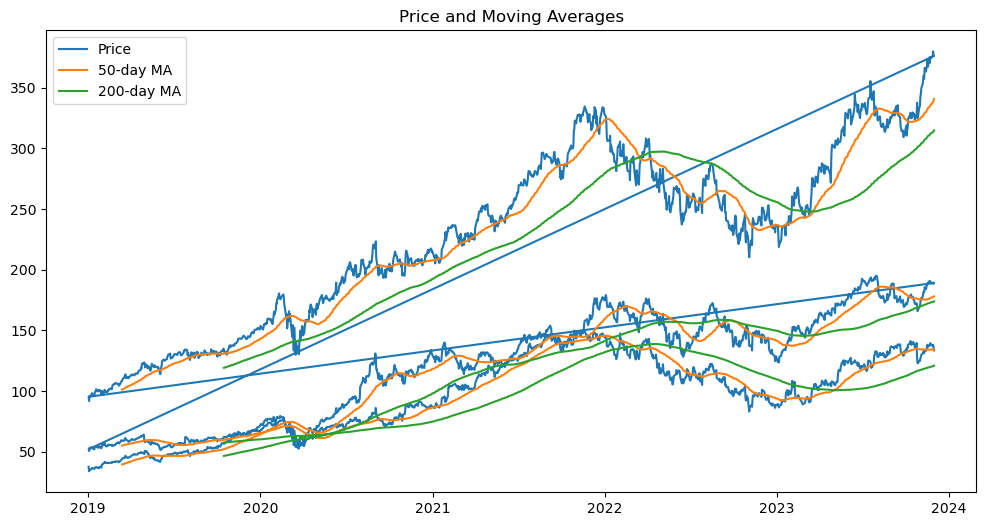

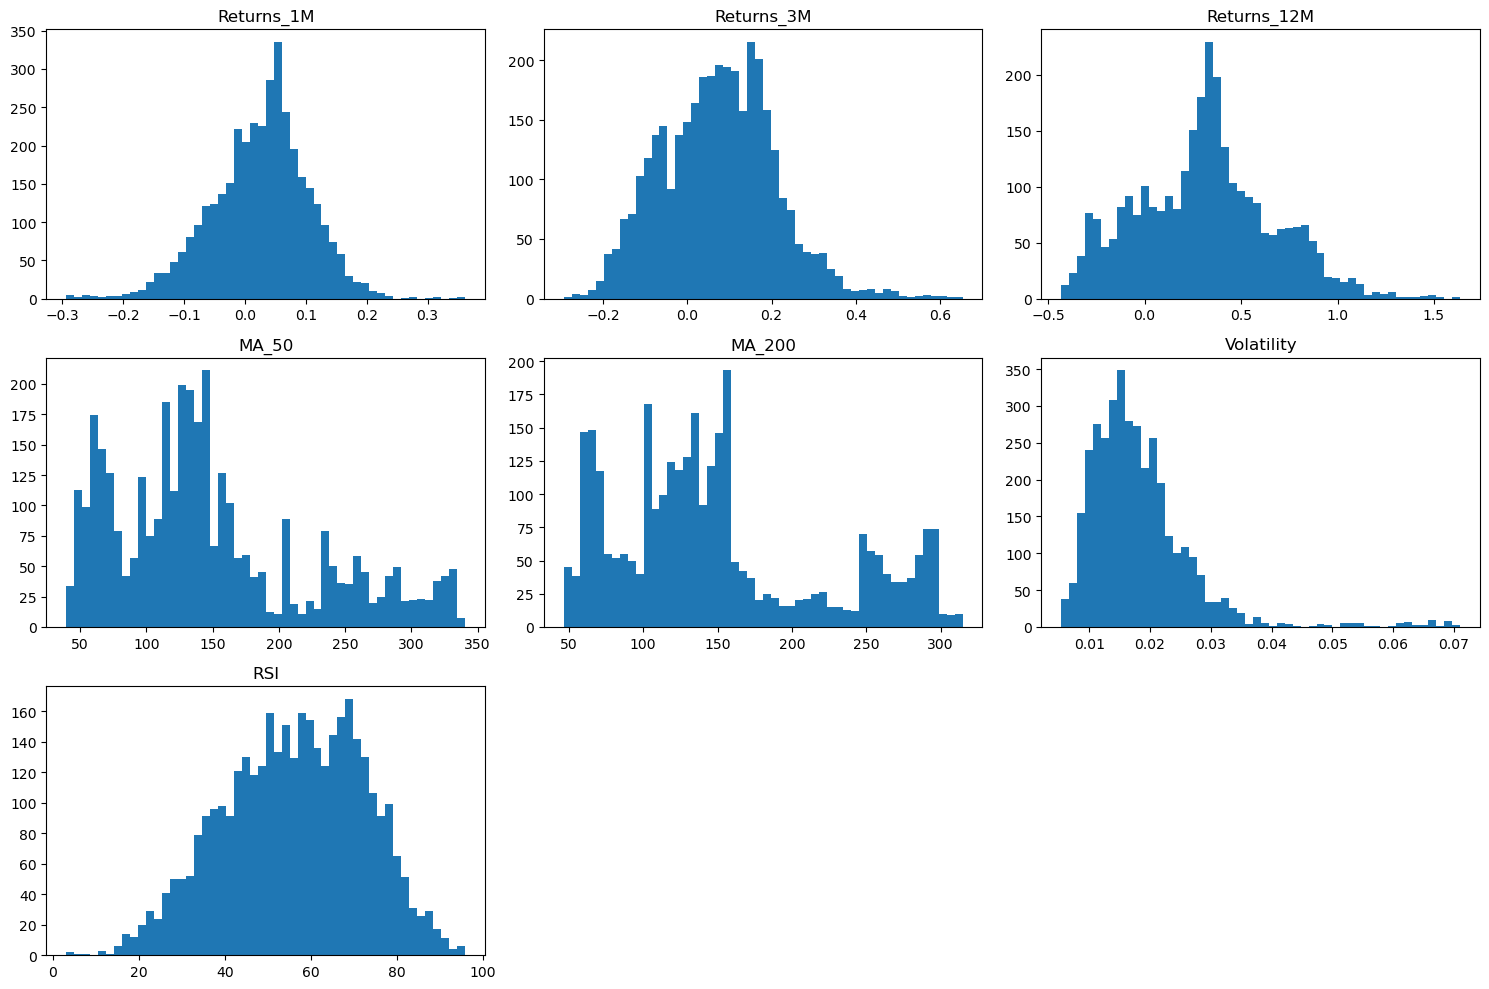

In [19]:
# calculating factors for our test data
processed_data = trader.calculate_factors()

# check
print("Available factors:", trader.factors)
print("\nFirst few rows of processed data:")
print(processed_data[['Ticker'] + trader.factors].head())

# diagnostic code
# grabbing  date in the middle of data
mid_date = processed_data.index[len(processed_data.index)//2]
print(f"\nData sample from around {mid_date}:")
print(processed_data[processed_data.index == mid_date][['Ticker'] + trader.factors])

print("\nNumber of valid rows per factor:")
for factor in trader.factors:
    valid_count = processed_data[factor].notna().sum()
    print(f"{factor}: {valid_count} valid rows")

# check 
for ticker in processed_data['Ticker'].unique():
    print(f"\nSample for {ticker}:")
    ticker_data = processed_data[processed_data['Ticker'] == ticker]
    print(ticker_data[trader.factors].iloc[100:105])  # middle rows

# visualizing
plt.figure(figsize=(12, 6))
plt.plot(processed_data.index, processed_data['Adj Close'], label='Price')
plt.plot(processed_data.index, processed_data['MA_50'], label='50-day MA')
plt.plot(processed_data.index, processed_data['MA_200'], label='200-day MA')
plt.title('Price and Moving Averages')
plt.legend()
plt.show()

plt.figure(figsize=(15, 10))
for i, factor in enumerate(trader.factors, 1):
    plt.subplot(3, 3, i)
    plt.hist(processed_data[factor].dropna(), bins=50)
    plt.title(factor)
plt.tight_layout()
plt.show()

In [20]:
def prepare_features(self, prediction_window=10):
    """
    modifying the features to include enhanced risk criteria and volume metrics
    """
    feature_data = self.data.copy()
    
    for ticker in feature_data['Ticker'].unique():
        mask = feature_data['Ticker'] == ticker
        price = feature_data.loc[mask, 'Adj Close']
        volume = feature_data.loc[mask, 'Volume'] # for volume
        
        # drawdown calculation
        rolling_max = price.rolling(window=252).max()
        drawdown = (price - rolling_max) / rolling_max
        feature_data.loc[mask, 'Drawdown'] = drawdown
        
        # volume metrics
        feature_data.loc[mask, 'Volume_Ratio'] = (
            volume / volume.rolling(window=20).mean()
        )
        
        # drawdown speed and acceleration
        feature_data.loc[mask, 'Drawdown_Speed'] = drawdown.diff(5)
        feature_data.loc[mask, 'Drawdown_Acceleration'] = feature_data.loc[mask, 'Drawdown_Speed'].diff()
        
        # volatility features
        returns = price.pct_change()
        feature_data.loc[mask, 'Volatility_21'] = returns.rolling(window=21).std()
        feature_data.loc[mask, 'Volatility_63'] = returns.rolling(window=63).std()
        
        # Volatility ratio
        feature_data.loc[mask, 'Volatility_Ratio'] = (
            feature_data.loc[mask, 'Volatility_21'] / 
            feature_data.loc[mask, 'Volatility_63']
        )
        
        # Moving averages
        feature_data.loc[mask, 'MA_50'] = price.rolling(window=50).mean()
        feature_data.loc[mask, 'MA_200'] = price.rolling(window=200).mean()
        feature_data.loc[mask, 'MA_Ratio'] = feature_data.loc[mask, 'MA_50'] / feature_data.loc[mask, 'MA_200']
        
        # risk target with multiple conditions
        future_returns = price.pct_change(prediction_window).shift(-prediction_window)
        
        # risk conditions
        severe_drawdown = drawdown < -0.12  # adjusted thresholds
        high_volatility = (
            feature_data.loc[mask, 'Volatility_21'] > 
            feature_data.loc[mask, 'Volatility_21'].rolling(50).mean() * 1.3
        )
        rapid_decline = feature_data.loc[mask, 'Drawdown_Speed'] < -0.05
        volume_spike = feature_data.loc[mask, 'Volume_Ratio'] > 2.0  # new
        
        # combining conditions for risk target
        feature_data.loc[mask, 'Target'] = (
            (severe_drawdown & (high_volatility | rapid_decline | volume_spike))
        ).astype(int)
        
    return feature_data.dropna()

In [21]:
def prepare_train_test(self, feature_data, train_end_date):
 
    train = feature_data[feature_data.index <= train_end_date]
    test = feature_data[feature_data.index > train_end_date]
    
    # grabbing all features except 'Target' and 'Ticker'
    feature_cols = [col for col in feature_data.columns if col not in ['Target', 'Ticker']]
    
    X_train = train[feature_cols]
    y_train = train['Target']
    X_test = test[feature_cols]
    y_test = test['Target']
    
    return X_train, X_test, y_train, y_test


Strategy.prepare_train_test = prepare_train_test

In [22]:
def calculate_feature_interactions(self, data):
    """interaction features between strongest predictors"""
    data = data.copy()
    # creating interaction features
    data['MA_200_x_Returns_3M'] = data['MA_200'] * data['Returns_3M']
    data['MA_Ratio'] = data['MA_50'] / data['MA_200']  # relative position of moving averages
    data['Trend_Strength'] = data['Returns_3M'] * data['Volatility']  # momentum adjusted for volatility
    return data

## training model

In [23]:
def train_model(self, X_train, y_train):

    # core risk features in our data
    risk_features = [
        'Drawdown', 'Drawdown_Speed', 'Volatility_21', 'Volatility_63',
        'Volatility_Ratio', 'MA_Ratio'
    ]
    
    X_train = X_train[risk_features]
    
    # class weights with moderation
    n_samples = len(y_train)
    n_risk = sum(y_train == 1)
    n_normal = sum(y_train == 0)
    
    class_weights = {
        0: 1.0,
        1: (n_normal / n_risk) * 0.8  # reduced the multiplier
    }
    
    self.model = DecisionTreeClassifier(
        max_depth=3,
        min_samples_leaf=40,
        min_samples_split=100,
        class_weight=class_weights,
        random_state=42
    )
    
    self.model.fit(X_train, y_train)
    
    return pd.DataFrame({
        'feature': risk_features,
        'importance': self.model.feature_importances_
    }).sort_values('importance', ascending=False)

In [24]:
def evaluate_model(self, X_test, y_test):

    from sklearn import metrics
    
    risk_features = [
        'Drawdown', 'Drawdown_Speed', 'Volatility_21', 'Volatility_63',
        'Volatility_Ratio', 'MA_Ratio'
    ]
    
    # features in X_test
    available_features = [f for f in risk_features if f in X_test.columns]
    X_test = X_test[available_features]
    
    y_pred = self.model.predict(X_test)
    
    # metrics
    conf_matrix = metrics.confusion_matrix(y_test, y_pred)
    classification_report = metrics.classification_report(y_test, y_pred)
    
    results = {
        'confusion_matrix': conf_matrix,
        'classification_report': classification_report
    }
    
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
    cm_display.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()
    
    # trading signals for further analysis
    test_data = X_test.copy()
    test_data['Predicted'] = y_pred
    test_data['Actual'] = y_test
    
    return results, test_data

In [25]:
def plot_tree_rules(self):

    plt.figure(figsize=(20,10))
    
    risk_features = ['Drawdown', 'Drawdown_Speed', 'Volatility_21', 'Volatility_63',
                    'Volatility_Ratio', 'MA_Ratio']
    
    plot_tree(self.model, 
             feature_names=risk_features,
             class_names=['No Risk', 'High Risk'],
             filled=True,
             rounded=True,
             fontsize=10)
    plt.show()

Feature Importance:
            feature  importance
0          Drawdown    0.583159
1    Drawdown_Speed    0.251938
4  Volatility_Ratio    0.164903
2     Volatility_21    0.000000
3     Volatility_63    0.000000
5          MA_Ratio    0.000000


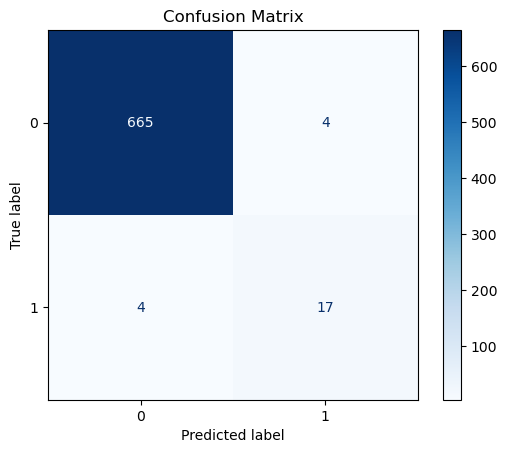


Model Performance:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       669
         1.0       0.81      0.81      0.81        21

    accuracy                           0.99       690
   macro avg       0.90      0.90      0.90       690
weighted avg       0.99      0.99      0.99       690


High Risk Predictions Sample:
            Drawdown  Drawdown_Speed  Volatility_21  Volatility_63  \
Date                                                                 
2023-02-21 -0.191057       -0.057539       0.021668       0.020369   
2023-02-22 -0.194771       -0.063968       0.021661       0.020378   
2023-02-08 -0.303827        0.011004       0.033256       0.026541   
2023-02-09 -0.335433       -0.070387       0.035114       0.027212   
2023-02-10 -0.339610       -0.072123       0.034484       0.027128   

            Volatility_Ratio  MA_Ratio  Predicted  Actual  
Date                                                       
2023-02-21 

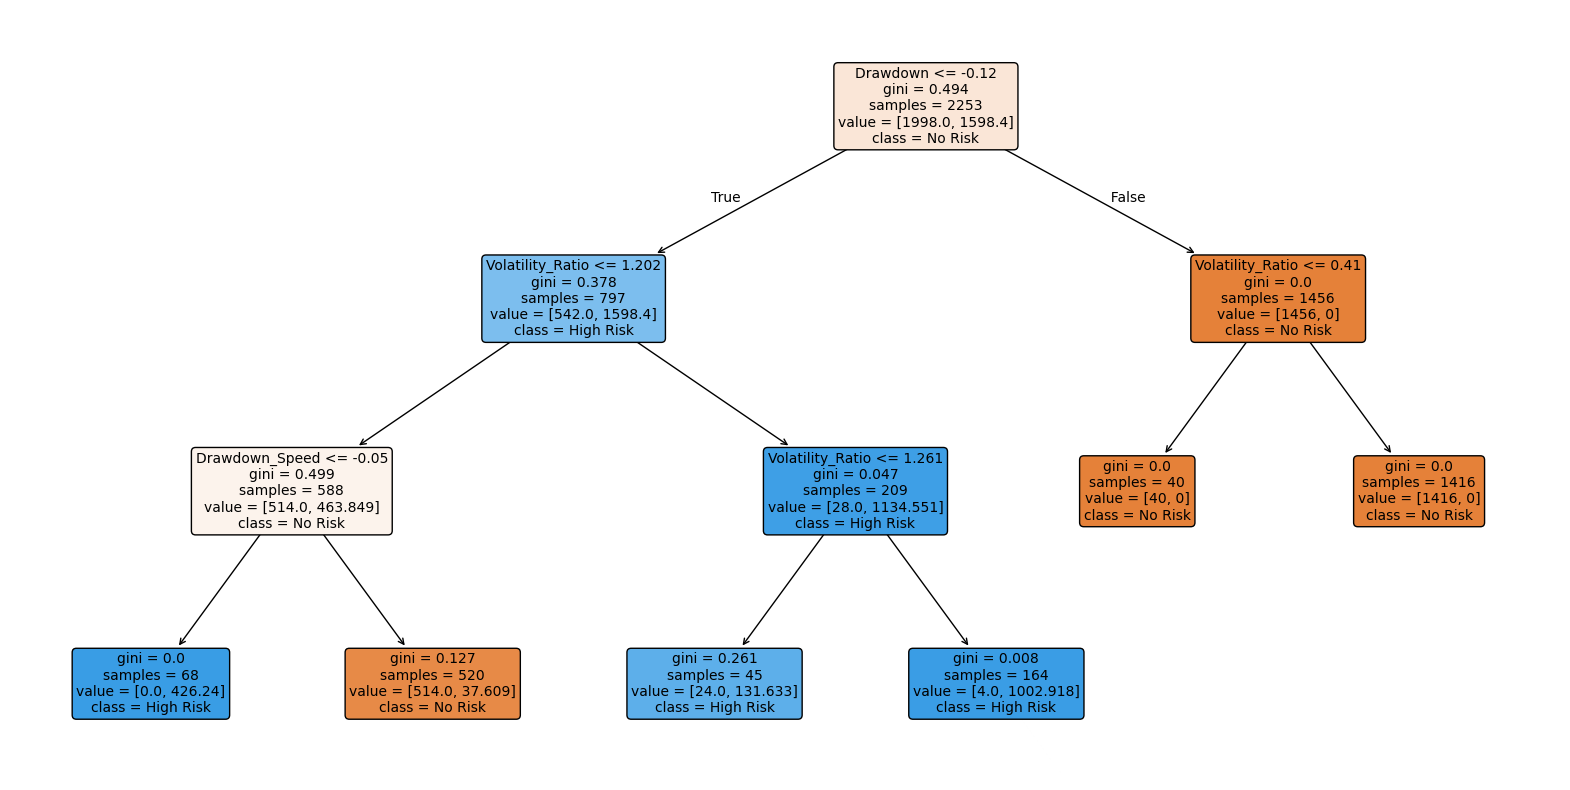

In [26]:
# adding methods to Strategy class
Strategy.train_model = train_model
Strategy.evaluate_model = evaluate_model
Strategy.calculate_feature_interactions = calculate_feature_interactions
Strategy.plot_tree_rules = plot_tree_rules
Strategy.prepare_features = prepare_features
Strategy.prepare_train_test = prepare_train_test



feature_data = trader.prepare_features(prediction_window=10)
X_train, X_test, y_train, y_test = trader.prepare_train_test(feature_data, '2022-12-31')

# training and evaluating
importance = trader.train_model(X_train, y_train)
print("Feature Importance:")
print(importance)

results, predictions = trader.evaluate_model(X_test, y_test)
print("\nModel Performance:")
print(results['classification_report'])

# showing high risk predictions
print("\nHigh Risk Predictions Sample:")
high_risk = predictions[predictions['Predicted'] == 1].head()
print(high_risk)

trader.plot_tree_rules()